In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../input/bike-sharing-demand/train.csv',parse_dates=[0])
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [4]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


## **Date Feature**

In [6]:
df['week'] = df['datetime'].dt.week
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month
df['dayofweek'] = df['datetime'].dt.dayofweek
df['year'] = df['datetime'].dt.year

In [7]:
def lag_features(df):
    for feature in ['temp','humidity', 'windspeed']:
        for hours in [1,2,3]:
            i = str(hours)
            df[feature + '_lag_' + i] = df[feature].shift(-hours)
            df[feature + '_lag_' + i] = np.where(df[feature + '_lag_' + i].isnull(),
                                                 df[feature],
                                                 df[feature + '_lag_' + i])
    return df

In [8]:
df = lag_features(df)

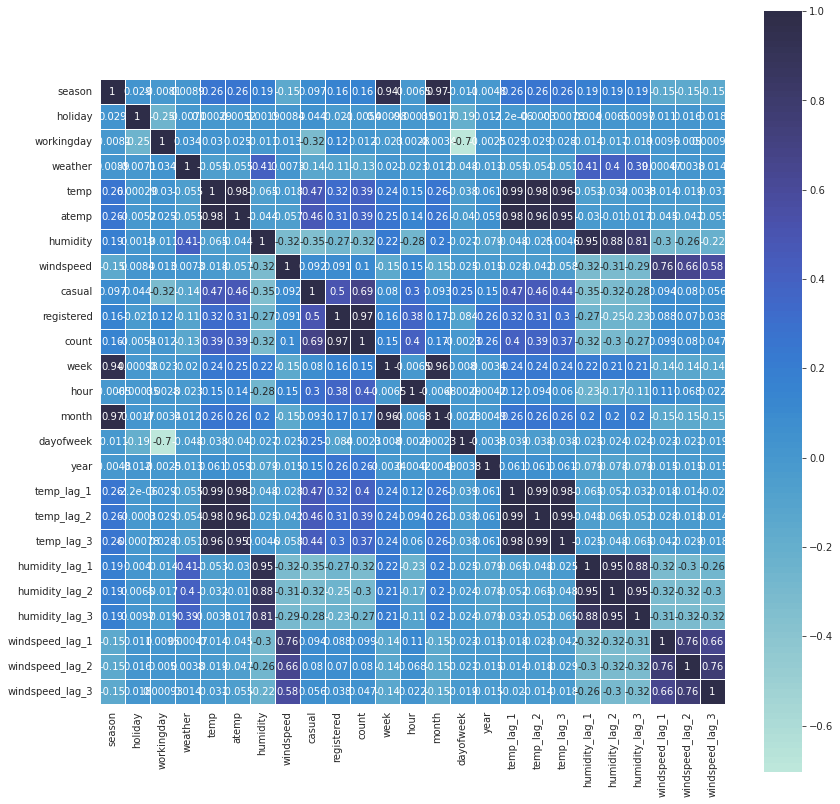

In [9]:
corr = df.drop(columns=['datetime'],axis=1).corr()
f,axes = plt.subplots(1,1,figsize = (14,14))
sns.heatmap(corr,square=True,annot = True,linewidth = .5,center = 1.4,ax = axes);

## Target

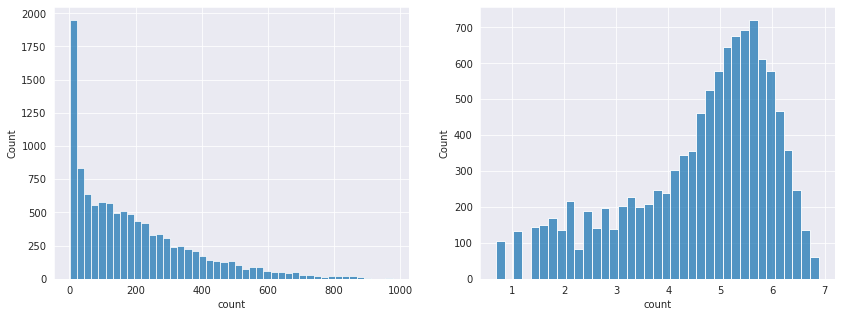

In [10]:
fig = plt.figure(figsize=(14,5))
ax_1 = fig.add_subplot(121)
sns.histplot(x='count',data=df,ax=ax_1)
ax_2 = fig.add_subplot(122)
sns.histplot(np.log1p(df['count']),ax=ax_2);
# df['count_log']= np.log1p(df['count'])

In [11]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, (np.maximum(y_pred, 0))))

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error,make_scorer
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=['datetime','casual', 'registered','count'],axis=1),
                                                 df['count'],
                                                 test_size=0.2,
                                                 shuffle=False)
y_train = np.log1p(y_train)
# score = make_scorer(rmsle,greater_is_better=False)
# param_search={'iterations':[100,150],
#              'learning_rate':[0.5,0.3],
#              'max_depth':[2,3,4]}
regressor = CatBoostRegressor(iterations=100,learning_rate=0.5,max_depth=3,verbose=False) 
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
print(f'rmsle:{rmsle(y_test,np.expm1(y_pred))}')
# tscv = TimeSeriesSplit(n_splits=10)

# model_cv = GridSearchCV(estimator=regressor, cv=tscv,
#                         param_grid=param_search,scoring=score)

# model_cv.fit(df.drop(columns=['datetime','casual', 'registered','count'],axis=1),df['count'])


rmsle:0.3081112759561435


In [13]:
from xgboost import XGBRegressor
xgb = XGBRegressor()

xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
print(f'rmsle:{rmsle(y_test,np.expm1(y_pred))}')

rmsle:0.4483672610066868


In [14]:
from sklearn.ensemble import VotingRegressor
model = VotingRegressor([('xgb',xgb), ('cat', regressor)], weights=[0.1, 0.9])

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(f'rmsle:{rmsle(y_test,np.expm1(y_pred))}')

rmsle:0.30539550289170786


In [15]:
X = df.drop(columns=['datetime','casual', 'registered','count'],axis=1)
Y = np.log1p(df['count'])
model.fit(X,Y)
print(rmsle(df['count'],np.expm1(model.predict(X))))

0.2745438918527428


## Submitting

In [16]:
df_test = pd.read_csv('../input/bike-sharing-demand/test.csv',parse_dates=[0])

df_test['week'] = df_test['datetime'].dt.week
df_test['hour'] = df_test['datetime'].dt.hour
df_test['month'] = df_test['datetime'].dt.month
df_test['dayofweek'] = df_test['datetime'].dt.dayofweek
df_test['year'] = df_test['datetime'].dt.year
df_test = lag_features(df_test)

X = df_test.drop(columns=['datetime'],axis=1)
pred = regressor.predict(X)

submission = pd.read_csv('../input/bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.maximum(np.expm1(pred),0)
submission.to_csv('my_submission.csv', index=False)